# Nigeria General Household Survey - Wave 3 (2015-2016)

## Calculate and visualize average food consumption across Nigeria
The data below is from the Nigeria General Household Survey - Wave 3 (2015-2016). It's [available](http://microdata.worldbank.org/index.php/catalog/2936/datafile/F11) on the WB Microdata Library.

With household survey data, sample weights are important to generalize from the sample to the population.

- **Objective: Calculate and visualize average food consumption across Nigeria's regions**

In [195]:
import pandas as pd
import numpy as np
import geopandas as gpd
import requests
from shapely.geometry import Point
import pylab as plt
%pylab inline
import seaborn as sns
import mplleaflet as mpll
import osmnx as ox
from IPython.display import Image
import matplotlib.pyplot as plt2

Populating the interactive namespace from numpy and matplotlib


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


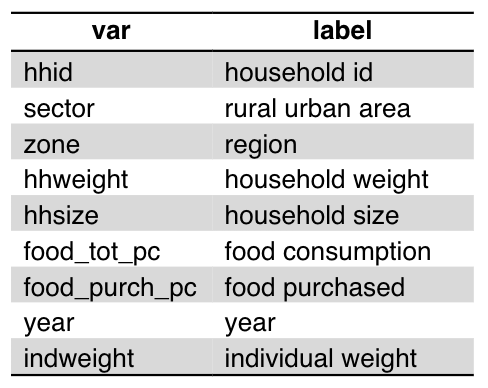

In [3]:
from IPython.display import Image
Image('data/nigeria_table.png', width = 250)

In [5]:
df2 = pd.read_csv('data/food2_pc.csv')

df2.rename(columns = {'hhweight':'household_weight','hhsize':'household_size','food_tot_pc':'food_consumption_pc',
           'food_purch_pc':'food_purchased_pc','indweight':'individual_weight'}, inplace=True)

df2.sector.replace({'1. URBAN': 'urban', '2. RURAL':'rural'}, inplace=True)
df2.zone.replace({'4. SOUTH EAST':'south_east', '2. NORTH EAST':'north_east', '5. SOUTH SOUTH':'south_south',
       '1. NORTH CENTRAL':'north_central', '6. SOUTH WEST':'south_west', '3. NORTH WEST':'north_west'}, inplace = True)

In [6]:
df2.head()

,hhid,sector,zone,household_weight,household_size,food_consumption_pc,food_purchased_pc,year,individual_weight
0,10001,urban,south_east,11898.656886,6,66134.52,66134.52,2016,71391.94
1,10002,urban,south_east,11898.656886,5,154360.40,154360.40,2016,59493.29
2,10003,urban,south_east,11898.656886,6,72695.84,72465.79,2016,71391.94
3,10004,urban,south_east,11898.656886,4,90533.04,90533.04,2016,47594.63
4,10005,urban,south_east,11898.656886,7,59554.59,59357.41,2016,83290.60


#### 1. Inspect data and remove outliers

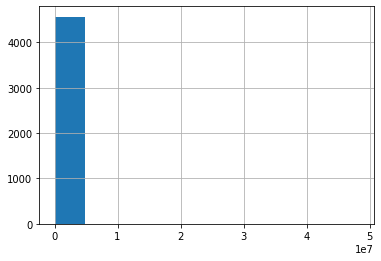

In [7]:
df2.food_consumption_pc.hist()

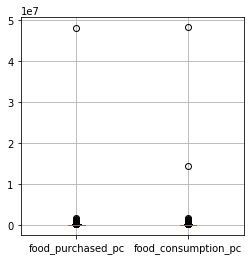

In [8]:
df2[['food_purchased_pc', 'food_consumption_pc']].boxplot(figsize = [4,4])

In [9]:
print(df2.food_purchased_pc.max())
print(df2.food_purchased_pc.mean())

48200000.0
71520.49595792302


In [10]:
# Remove observations more than 3 standard deviations above the mean

df2['food_purchased_pc'][df2['food_purchased_pc'] > (df2.food_purchased_pc.mean()
                                                     + df2.food_purchased_pc.std() * 3)] = np.nan
df2['food_consumption_pc'][df2['food_consumption_pc'] > (df2.food_consumption_pc.mean() 
                                                         + df2.food_consumption_pc.std() * 3)] = np.nan
df2.dropna(inplace = True)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [11]:
print(df2.food_purchased_pc.max())
print(df2.food_purchased_pc.mean())

1788152.0
60952.09905321461


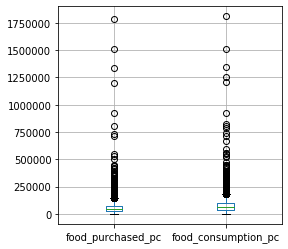

In [12]:
df2[['food_purchased_pc', 'food_consumption_pc']].boxplot(figsize = [4,4])

#### 2. Calculate mean food consumption by region, and by rural / urban.

The Pandas groupby function makes this easy. It does three things:
* Split the data into groups.
* Apply a function to each group independently (eg. sum, mean, counts).
* Combine the results into a data structure.

In [13]:
df2.groupby(['zone'])['food_consumption_pc'].mean()

zone
north_central     68276.045109
north_east        62701.572977
north_west        55262.463779
south_east        93867.487344
south_south      117532.042266
south_west        90956.257569
Name: food_consumption_pc, dtype: float64

We plotted mean food consumption among 5000 surveyed households; doesn't represent population as a whole!

#### 3. Calculate mean food consumption for population

Weighted mean:

$$\overline x = \frac{\sum wx}{\sum w}$$

ie. sum of values times weights / sum of weights

In [15]:
sum(df2.food_purchased_pc * df2.individual_weight) / df2.household_weight.sum()

289663.4699519813

In [17]:
def weighted_mean(values, weights):
    return sum(values * weights) / weights.sum()

In [18]:
weighted_mean(values = df2.food_purchased_pc[df2.zone == 'south_east'],
             weights = df2.household_weight[df2.zone == 'south_east'])

73451.24198885933

The weighted mean for South East is 73,451 whereas the simple mean food consumption is misleadingly 93,867. So let us produce weighted means for all regions

In [19]:
weighted_means_table = pd.Series({zone: weighted_mean(df2.food_consumption_pc[df2.zone == zone],
                                  df2.household_weight[df2.zone == zone]) for zone in df2.zone.unique()},
                                name = 'mean_food_consumption_pc')

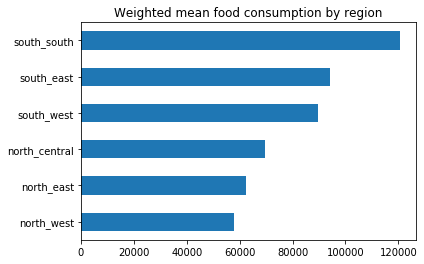

In [21]:
weighted_means_table.sort_values(ascending = True).plot(kind='barh')
plt.title('Weighted mean food consumption by region');

#### 4. Visualize on a map of Nigeria
* A good data source is GADM, which has admin boundaries for all countries at levels 0 through 3 (national boundaries through to ward level). https://gadm.org/


* GADM1 gives us Nigeria's 36 states and capital territory. Our dataset uses the six [Geopolitical Zones](https://en.wikipedia.org/wiki/Geopolitical_zones_of_Nigeria) of Nigeria instead (these each comprise about 5-8 states). Create the required polygons by aggregating the state boundaries using Geopandas [dissolve](http://geopandas.org/aggregation_with_dissolve.html) function.

In [22]:
nigeria_GADM = gpd.read_file('data/nigeria/gadm36_NGA_1.shp')

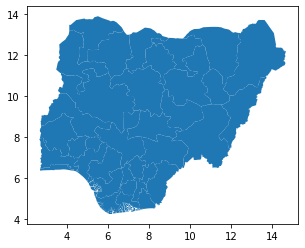

In [23]:
nigeria_GADM.plot()

Ensure the region names in our data match those in the GADM shapefile

In [28]:
north_central = ['Benue','Kogi','Kwara', 'Nassarawa', 'Niger','Plateau', 'Federal Capital Territory']
north_east = ['Adamawa', 'Bauchi', 'Borno', 'Gombe', 'Taraba', 'Yobe']
north_west = ['Jigawa', 'Kaduna', 'Kano', 'Katsina', 'Kebbi', 'Sokoto', 'Zamfara']
south_east = ['Abia', 'Anambra', 'Ebonyi', 'Enugu', 'Imo']
south_south = ['Akwa Ibom', 'Bayelsa', 'Cross River', 'Rivers', 'Delta', 'Edo']
south_west = ['Ekiti', 'Lagos', 'Ogun', 'Ondo', 'Osun', 'Oyo']

def remap_states(state):
    if state in north_east:
        return('north_east')
    elif state in north_central:
        return('north_central')
    elif state in north_west:
        return('north_west')
    elif state in south_east:
        return('south_east')
    elif state in south_south:
        return('south_south')
    elif state in south_west:
        return('south_west')
    else:
        return('error!')

A quick way to transform the rows or columns of a DataFrame is df.apply(). This runs a function of your choice across all the rows (axis = 0, the default) or all the columns (axis = 1).

In [29]:
nigeria_GADM.head(2)

,GID_0,NAME_0,GID_1,NAME_1,VARNAME_1,NL_NAME_1,TYPE_1,ENGTYPE_1,CC_1,HASC_1,geometry
0,NGA,Nigeria,NGA.1_1,Abia,None,None,State,State,None,NG.AB,"POLYGON ((7.48997593 4.85505676, 7.49437714 4...."
1,NGA,Nigeria,NGA.2_1,Adamawa,None,None,State,State,None,NG.AD,"POLYGON ((12.01237392 7.50763273, 12.00726032 ..."


In [30]:
nigeria_GADM['region'] = nigeria_GADM.NAME_1.apply(remap_states)

In [31]:
# Create a new geodataframe comprising six merged polygons

regions = nigeria_GADM.dissolve(by = 'region')

In [36]:
regions.head(10) # this calls for the first 10 but we get 6 because there are 6 regions

,geometry,GID_0,NAME_0,GID_1,NAME_1,VARNAME_1,NL_NAME_1,TYPE_1,ENGTYPE_1,CC_1,HASC_1
region,,,,,,,,,,,
north_central,"POLYGON ((7.82773113 6.63026714, 7.82988024 6....",NGA,Nigeria,NGA.7_1,Benue,None,None,State,State,None,NG.BE
north_east,"POLYGON ((10.1536665 7.03837299, 10.15335178 7...",NGA,Nigeria,NGA.2_1,Adamawa,None,None,State,State,None,NG.AD
north_west,"POLYGON ((5.43651819 11.02907562, 5.43641996 1...",NGA,Nigeria,NGA.18_1,Jigawa,None,None,State,State,None,NG.JI
south_east,"POLYGON ((7.48997593 4.85505676, 7.49437714 4....",NGA,Nigeria,NGA.1_1,Abia,None,None,State,State,None,NG.AB
south_south,"(POLYGON ((6.58263922 4.67208385, 6.58263922 4...",NGA,Nigeria,NGA.3_1,Akwa Ibom,None,None,State,State,None,NG.AK
south_west,"(POLYGON ((4.99680519 5.86319399, 4.99680519 5...",NGA,Nigeria,NGA.13_1,Ekiti,None,None,State,State,None,NG.EK


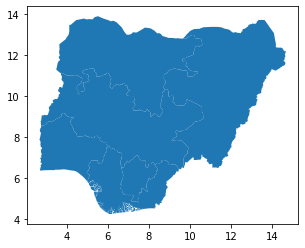

In [33]:
regions.plot()

In [34]:
# Check the two frames have the same length before merging

regions.shape

(6, 11)

In [37]:
weighted_means_table.shape

(6,)

In [38]:
regions_merged = pd.merge(regions, weighted_means_table, left_index=True, right_index=True)

In [39]:
regions_merged = gpd.GeoDataFrame(regions_merged)

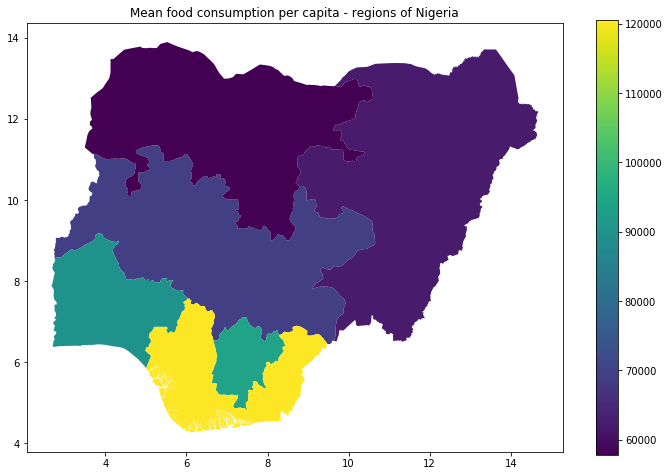

In [40]:
regions_merged.plot(column = 'mean_food_consumption_pc', legend = True, figsize = [12,8])
plt.title('Mean food consumption per capita - regions of Nigeria');